### 회귀모델

In [7]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest# 환경 설정

import matplotlib
# 한글 설치(윈도우 버전)
matplotlib.rc('font',family='Malgun Gothic')
# 음수 표시
matplotlib.rc('axes',unicode_minus=False)
# 그래프 출력
%matplotlib inline

# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

#### 코스피 기준 기업 
- Code 엔티티를 Read 와 동시에 결측치가 있는 행을 제거
- windows size를 5일 예측 기간 1일로 선정 (이유 : 일주일 단위로 7일하면 휴일 기준 5일치만 수치가 나옴),(예측 기간은 1일만 알아도 충분하다고 판단)
- Close를 타겟(Y)으로 하여, 현재 윈도우와 그에 따른 예측 값을 추출

In [14]:
import FinanceDataReader as fdr

KOSPI=fdr.StockListing('KOSPI')
KOSPI.head(20)

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,78200,2,-700,-0.89,77900,78600,77800,5792013,452587215400,466836995410000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,193100,2,-6600,-3.30,193000,195400,191100,3585131,690799885200,140577256681500,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,349500,1,19500,5.91,333000,353000,332000,421041,146231754500,81783000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,934000,1,27000,2.98,913000,936000,913000,104559,96925209000,66476516000000,71174000,STK
4,005380,KR7005380001,현대차,KOSPI,,253000,2,-3000,-1.17,257500,257500,251000,268753,68002119000,52982296323000,209416191,STK
5,005935,KR7005931001,삼성전자우,KOSPI,,62700,2,-200,-0.32,62500,62900,62300,338718,21221721700,51594996090000,822886700,STK
6,068270,KR7068270008,셀트리온,KOSPI,,199500,1,3300,1.68,198000,199900,196700,587255,116550198100,43295727405000,217021190,STK
7,000270,KR7000270009,기아,KOSPI,,103000,2,-400,-0.39,103400,103900,102300,409258,42152923000,41185416951000,399858417,STK
8,105560,KR7105560007,KB금융,KOSPI,,87300,2,-2600,-2.89,89600,89600,86900,685620,60208084000,35226516585600,403511072,STK
9,055550,KR7055550008,신한지주,KOSPI,,58000,2,-400,-0.68,58600,59200,57500,892547,52096091300,29544806412000,509393214,STK


In [17]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 분석할 주식 코드 목록
stock_codes = ['005930', '000660', '373220', '207940','004100','011700','481850','120030','015590','019440','003610',
               '077500','396690','012600','017900','000180','014710','350520','023450','267290','111380','008260','163560']

# 빈 리스트를 만들어서 모든 주식 데이터를 통합할 준비
X = []
Y = []

# 각 주식 코드에 대해 데이터 불러오고 처리
for code in stock_codes:
    df = fdr.DataReader(code).dropna()  # 데이터 불러오기 및 결측값 제거
    
    # 주식 데이터가 비어있지 않은 경우에만 처리
    if not df.empty:
        # 'Close' 열의 데이터만 사용
        close_prices = df['Close'].values
        
        # 윈도우 사이즈와 예측 기간 설정
        window_size = 5  # 윈도우 사이즈 (일수)
        next_date = 1     # 예측 기간 (일수)
        
        for i in range(len(close_prices) - window_size - next_date):
            # 현재 윈도우와 그에 따른 예측 값을 추출
            window = close_prices[i:i + window_size]
            target = close_prices[i + window_size + next_date]
            
            X.append(window)
            Y.append(target)


# X와 Y를 numpy 배열로 변환
X = np.array(X)
Y = np.array(Y)


##### 랜덤포레스트
- R2가 99로 너무 높아 사용할 수 없다고 판단

In [24]:
# 데이터 분할 (훈련 데이터와 테스트 데이터)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)


# 랜덤 포레스트 회귀 모델 생성 및 학습
model = RandomForestRegressor()
model.fit(X_train, Y_train)

# 테스트 데이터에 대해 예측 수행
Y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

r2_score = model.score(X_test, Y_test)
print(f'R^2 Score: {r2_score}')

# 예측 결과 확인
print('Sample Predictions:')
for i in range(min(5, len(Y_pred))):
    print(f'Actual: {Y_test[i]}, Predicted: {Y_pred[i]}')

Mean Squared Error: 14629811.072676405
R^2 Score: 0.9985660084421122
Sample Predictions:
Actual: 400, Predicted: 408.27
Actual: 2490, Predicted: 2490.0
Actual: 12900, Predicted: 12772.69
Actual: 755, Predicted: 767.97
Actual: 2415, Predicted: 2471.35


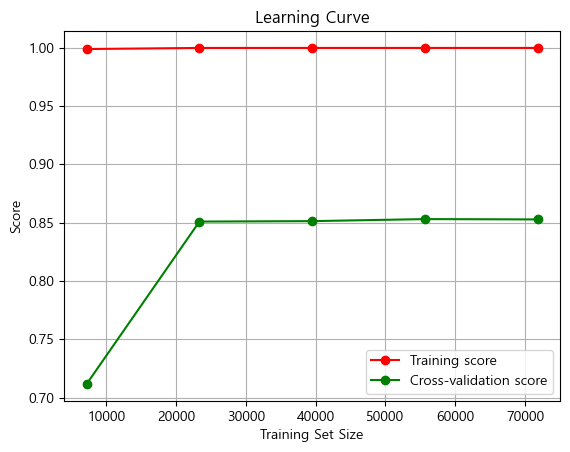

In [29]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=5, scoring='r2')

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Learning Curve 시각화
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')

plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


##### XGBoost
- R2가 너무 낮아 사용할 수 없다고 판단
- (하이퍼파라미터 조정을 하기전엔 음수로 나옴, 하고난 후 양수로 나옴 하지만 설명력이 너무 낮음)
- 0.001 나옴

In [36]:
import xgboost as xgb

# XGBoost 회귀 모델 생성 및 학습
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

# XGBoost 회귀 모델 생성 및 하이퍼파라미터 조정
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse', 
    learning_rate=0.1,  # 낮은 학습률
    n_estimators=500,    # 더 많은 트리
    max_depth=5,         # 적당한 깊이
    subsample=0.8,       # 데이터 샘플 비율
    colsample_bytree=0.8, # 특성 샘플 비율
    alpha=0.1,           # L1 정규화
         # L2 정규화
    random_state=42
)
model.fit(X_train, Y_train)

# 테스트 데이터에 대해 예측 수행
Y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

r2_score = model.score(X_test, Y_test)
print(f'R^2 Score: {r2_score}')

# 예측 결과 확인
print('Sample Predictions:')
for i in range(min(5, len(Y_pred))):
    print(f'Actual: {Y_test[i]}, Predicted: {Y_pred[i]}')

Mean Squared Error: 30127375.254692964
R^2 Score: 0.9970469610604039
Sample Predictions:
Actual: 400, Predicted: 427.5582275390625
Actual: 2490, Predicted: 2426.091552734375
Actual: 12900, Predicted: 12994.4306640625
Actual: 755, Predicted: 772.51416015625
Actual: 2415, Predicted: 2426.091552734375


##### 회귀 DateFrame

In [44]:
import pandas as pd

# X를 데이터프레임으로 변환, 각 컬럼은 윈도우의 하루치를 나타냄
X_df = pd.DataFrame(X, columns=[f'Window_{i+1}' for i in range(X.shape[1])])

# Y를 데이터프레임으로 변환
Y_df = pd.DataFrame(Y, columns=['Target'])

# X와 Y를 합쳐서 하나의 데이터프레임으로 만들기
df_final = pd.concat([X_df, Y_df], axis=1)

df_final.head(15)


,Window_1,Window_2,Window_3,Window_4,Window_5,Target
0,6180,6560,6370,6350,6160,6800
1,6560,6370,6350,6160,6440,6920
2,6370,6350,6160,6440,6800,6800
3,6350,6160,6440,6800,6920,6900
4,6160,6440,6800,6920,6800,6670
5,6440,6800,6920,6800,6900,6380
6,6800,6920,6800,6900,6670,6200
7,6920,6800,6900,6670,6380,6000
8,6800,6900,6670,6380,6200,5600
9,6900,6670,6380,6200,6000,5460


### 분류
- target을 상승/하락으로 